In [139]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
from Copter.Session import Session
from Copter.Network import Network
net = Network(3, 2)
s = Session(net, std=50, step_size=1e-3, jerk_loss_coeff=1.0)

In [141]:
s.train_model(100, 100)

d:\STUDY\code\ML notebooks\my\copter\utils.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  min_value, max_value = torch.tanh(torch.tensor(-scale_factor)), torch.tanh(torch.tensor(scale_factor))


-582987274.921875 100
-583957070.6640625 100
-585483727.4375 100
-580600277.8984375 100
-556676786.875 100
-373620529.3125 82
-148749219.828125 53
-82309359.0625 45
-61096876.310546875 45
-46585465.638671875 48
-41785081.21875 53
-38741480.220703125 55
-31602119.94366455 58
-26760510.075195312 61
-17336913.493164062 60
-15350111.948242188 63
-16098712.903442383 88
-13001566.02002716 65
-13897227.8984375 64
-14744862.998413086 64
-10012844.3984375 71
-9745751.900550842 85
-10071151.353874207 72
-12527690.474334717 75
-13622093.34908104 80
-13587832.635742188 61
-15437105.688423157 55
-23349958.873443604 43
-687665.8914990425 30
-825250.0538320541 29
-899685.5632910728 29
-953694.5635447502 29
-965611.9746623039 29
-962689.342508316 29
-1032051.1102581024 29
-756006.1643371582 29
-722302.3254933357 30
-1081067.687728405 29
-759791.3906440735 29
-800985.5897951126 29
-793700.824461937 29
-744382.36267519 29
-748261.1120867729 30
-1075744.0840086937 29
-751101.4894323349 29
-831739.1369166

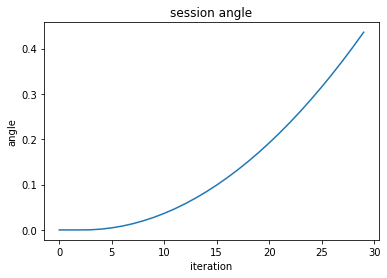

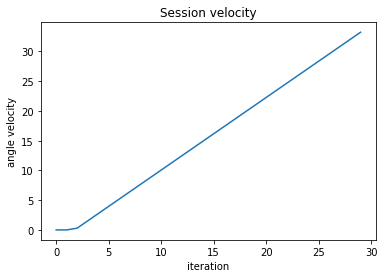

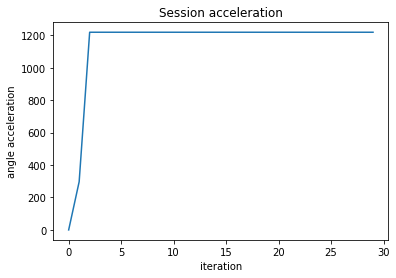

In [142]:
s.plot_states()

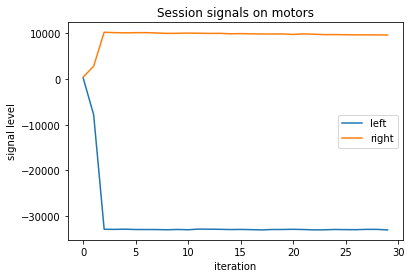

In [144]:
s.plot_actions()

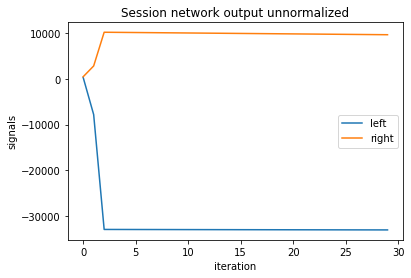

In [145]:
s.plot_signals()

In [14]:
from utils import compute_total_J
compute_total_J(False)

21.8


12956637.786666665

In [63]:
from Copter.Session import Session
s = Session()
s.run(10)

d:\STUDY\code\ML notebooks\my\copter\Copter\TwoMotorStick.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probas = F.softmax(logits).numpy()


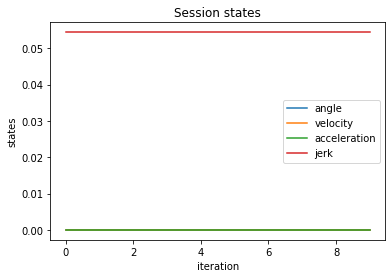

In [64]:
s.plot_states()

In [1]:
# all parameters in mm's and gramms

# STICK_LENGTH = 370.
# STICK_HEIGHT = 59.
# STICK_MASS = 196.

# MOTOR_MASS = 67.
# MOTOR_DISTANCE = 158.
# MOTOR_HEIGHT = 50.

# REGULATOR_MASS = 24.
# REGULATOR_DISTANCE = 70.
# REGULATOR_HEIGHT = 32.

# CENTER_AXIS_IDENT = 17.5
# PILLAR_HEIGH = 0
from model_parameters import *
2 * (MOTOR_MASS * MOTOR_HEIGHT + REGULATOR_MASS * REGULATOR_HEIGHT) \
    / (2 * MOTOR_MASS + 2 * REGULATOR_MASS + STICK_MASS)

21.788359788359788

In [1]:
import torch

In [10]:
a = torch.tensor([1, 2, 3])
b = torch.tensor([4, 5, 6])
c = torch.vstack([a, b])
torch.square(c)

tensor([[ 1,  4,  9],
        [16, 25, 36]])

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch


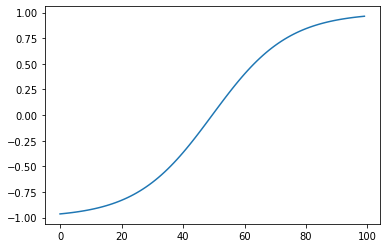

In [22]:
space = np.linspace(-2, 2, 100)
ans = []
for a in space:
    ans.append(torch.tanh(torch.tensor(a)).item())
plt.plot(ans)

In [44]:
import math
mean = 1
var = 1

In [45]:
np.random.normal(mean, var)

1.3196001152839887

In [46]:
a = np.array([1, 3])
a.tolist()

[1, 3]

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [167]:
df = pd.read_csv('Motor force detection.csv')

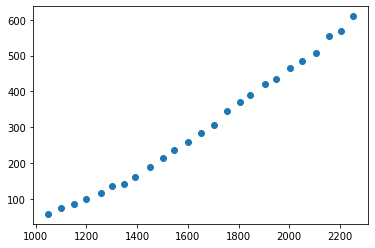

In [168]:
plt.scatter(x=df.input, y=df.mass)

In [169]:
lr = LinearRegression()
lr.fit(df.drop('mass', axis=1), df.mass)

LinearRegression()

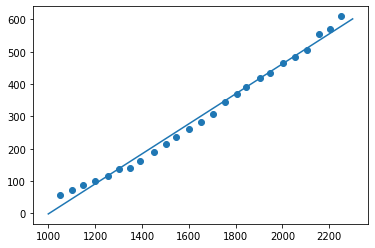

In [170]:
space = np.linspace(1000, 2300)
preds = lr.intercept_ + lr.coef_[0] * space
plt.plot(space, preds)
plt.scatter(x=df.input, y=df.mass)
plt.show()

In [171]:
np.array([lr.intercept_, lr.coef_[0]]) * 1e-3 * 9.8

array([-4.56204418e+00,  4.54791687e-03])

In [172]:
lr.predict(np.array([[2300]]))

array([601.85353414])